In [1]:
library(tidyverse)
library(repr)
library(RColorBrewer)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
pulsar_data <- read_csv("https://github.com/kseniak1/DSCI100-Group-Project/raw/main/HTRU_2%5B1%5D.csv", col_names = FALSE) %>%
                rename(mean_ip = X1,
                      dev_ip = X2,
                      excess_ip = X3,
                      skewness_ip = X4,
                      mean_dm = X5,
                      dev_dm = X6,
                      excess_dm = X7,
                      skewness_dm = X8,
                      class = X9)
pulsar_data

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



mean_ip,dev_ip,excess_ip,skewness_ip,mean_dm,dev_dm,excess_dm,skewness_dm,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


In [3]:
## Table of maximum values in each column
max_data <- pulsar_data %>%
            map_dfr(max) %>%
            pivot_longer(cols = mean_ip:class, names_to = "value", values_to = "max")

## Table of minimum values in each column
min_data <- pulsar_data %>%
            map_dfr(min) %>%
            pivot_longer(cols = mean_ip:class, names_to = "value", values_to = "min")

mean_data <- pulsar_data %>%
            map_dfr(mean) %>%
            pivot_longer(cols = mean_ip:class, names_to = "value", values_to = "mean")

## Combined min, max and mean data 
min_max_mean_data <- bind_cols(min_data, max_data, mean_data) %>%
                rename(value = value...1) %>%
                select(value, max, min, mean)

min_max_mean_data

## Count number of pulsar and non-pulsar datapoints
pulsar_count <- pulsar_data %>%
                group_by(class) %>%
                summarize(n = n()) %>%
                select(class, n)
pulsar_count

New names:
* value -> value...1
* value -> value...3
* value -> value...5



value,max,min,mean
<chr>,<dbl>,<dbl>,<dbl>
mean_ip,192.617188,5.8125000,111.07996834
dev_ip,98.778911,24.7720418,46.54953156
excess_ip,8.069522,-1.8760112,0.47785726
skewness_ip,68.101622,-1.7918860,1.77027900
mean_dm,223.392141,0.2132107,12.61439966
dev_dm,110.642211,7.3704322,26.32651470
excess_dm,34.539844,-3.1392696,8.30355612
skewness_dm,1191.000837,-1.9769756,104.85770870
class,1.000000,0.0000000,0.09157448


`summarise()` ungrouping output (override with `.groups` argument)



class,n
<dbl>,<int>
0,16259
1,1639


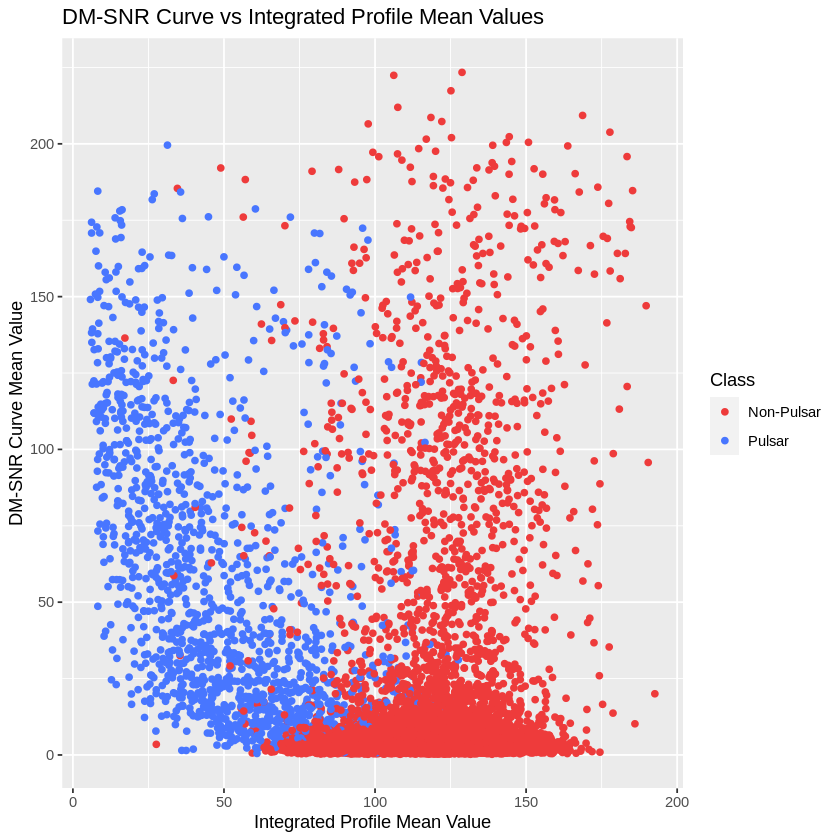

In [4]:
means_graph <- ggplot(pulsar_data, aes(x = mean_ip, y = mean_dm, color = as_factor(class))) +
                geom_point() +
                labs(x = "Integrated Profile Mean Value", y = "DM-SNR Curve Mean Value", color = "Class") +
                ggtitle("DM-SNR Curve vs Integrated Profile Mean Values") +
                scale_color_manual(labels = c("Non-Pulsar", "Pulsar"), values = c("brown2", "royalblue1"))
means_graph